In [23]:
# Graph Mining - ALTEGRAD - Oct 2023

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
from scipy.sparse import diags, eye
from random import randint
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Part 1

In [25]:
############## Task 1

##################
G = nx.read_edgelist(path='CA-HepTh.txt', delimiter='\t')
print("Number of Nodes:")
print(G.number_of_nodes())
print("Number of Edges:")
print(G.number_of_edges())
##################



Number of Nodes:
9877
Number of Edges:
25998


In [26]:
############## Task 2

##################
print("Number of Connected Components:")
print(nx.number_connected_components(G))
# Extract largest connected component subgraph
G_ls = G.subgraph(max(nx.connected_components(G), key=len))
print("Number of Nodes of largest connected component subgraph:")
print(G_ls.number_of_nodes())
print("Number of Edges of largest connected component subgraph:")
print(G_ls.number_of_edges())
print("Fraction of Nodes of largest connected component subgraph:")
print(G_ls.number_of_nodes()/G.number_of_nodes())
print("Fraction of Edges of largest connected component subgraph:")
print(G_ls.number_of_edges()/G.number_of_edges())
##################

Number of Connected Components:
429
Number of Nodes of largest connected component subgraph:
8638
Number of Edges of largest connected component subgraph:
24827
Fraction of Nodes of largest connected component subgraph:
0.8745570517363572
Fraction of Edges of largest connected component subgraph:
0.9549580736979768


In [27]:
############## Task 3

# Degree
degree_sequence = np.array([G.degree(node) for node in G.nodes()])

##################
print("Min degree of nodes:")
print(np.min(degree_sequence))
print("Max degree of nodes:")
print(np.max(degree_sequence))
print("Mean degree of nodes:")
print(np.mean(degree_sequence))
##################

Min degree of nodes:
1
Max degree of nodes:
65
Mean degree of nodes:
5.264351523742027


[]

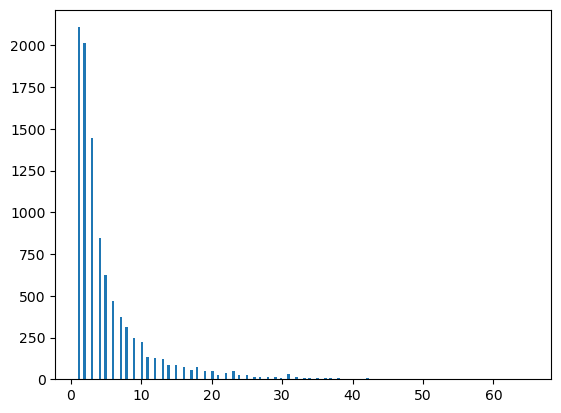

In [28]:
############## Task 4

##################
degree_G = [val for (node, val) in G.degree()]
plt.hist(degree_G, bins='auto')
#plt.xscale('log')
#plt.yscale('log')
plt.plot()
##################

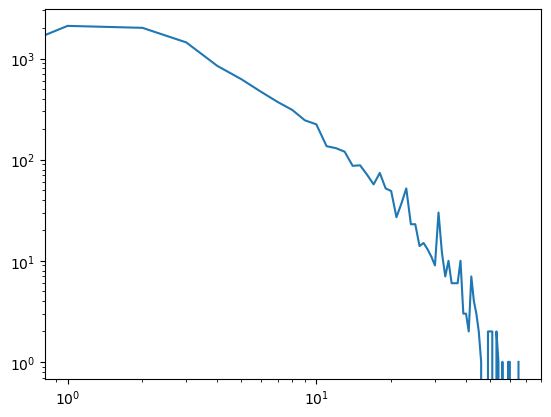

In [29]:
############## Task 4

##################
hist = nx.degree_histogram(G)
plt.loglog(hist)
##################

In [32]:
############## Task 5

##################
print("Global clustering coefficient:")
print(nx.transitivity(G))
##################

Global clustering coefficient:
0.2839996525875546


# Part 2

In [45]:
############## Task 6

# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):   
    ##################
    nb_nodes = G.number_of_nodes()
    A = nx.adjacency_matrix(G)
    D_inv=diags([1 / G.degree(node) for node in G.nodes()])

    Lrw = np.eye(nb_nodes) - np.dot(D_inv,A)
    eigenvalues, eigenvectors = eigs(Lrw,k,which='SR')
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
 
    kmeans_clustering = KMeans(n_clusters=k)
    kmeans_clustering.fit(eigenvectors)
    list_nodes=list(G.nodes.keys())
    clustering={list_nodes[i]:kmeans_clustering.labels_[i] for i in range(nb_nodes)}
    ##################
    return clustering

In [46]:
############## Task 7

##################
clustering = spectral_clustering(G_ls, 50)
##################


/Users/elyas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
############## Task 8

# Compute modularity value from graph G based on clustering
def modularity(G, clustering):
    ##################
    m = G.number_of_edges()
    n_clusters = len(set(clustering.values()))
    modularity=0
    for cluster in set(clustering.values()):
        subgraph_nodes = []
        for j in G.nodes():
            if clustering[j]==cluster:
                subgraph_nodes.append(j)
        subgraph = G.subgraph(subgraph_nodes)
        l_c = subgraph.number_of_edges()
        d_c = sum([G.degree(node) for node in subgraph_nodes])
        modularity+=l_c/m-(d_c/(2*m))**2
    ##################
    
    return modularity

In [49]:
############## Task 9

##################
print('Modularity for previous clustering:')
print(modularity(G_ls, clustering))
random_clustering={node:randint(0,49) for node in G_ls.nodes()}

print('Modularity for random clustering:')
print(modularity(G_ls, random_clustering))
##################

Modularity for previous clustering:
0.1547785359506735
Modularity for random clustering:
0.00017252751914314802


# Part 3

In [50]:
############## Task 10

# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    ##################
    Gs_cycle = [nx.cycle_graph(n) for n in range(3, 103)]
    Gs_path = [nx.path_graph(n) for n in range(3, 103)]
    Gs = Gs_cycle + Gs_path
    
    y_cycle = [0 for n in range(100)]
    y_path = [1 for n in range(100)]
    y = y_cycle + y_path
    ##################

    return Gs, y

Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

In [51]:
# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]
    
  
    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)

In [52]:
############## Task 11

# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    phi_train = np.zeros((len(G_train), 4))
    
    ##################
    for i, graph in enumerate(Gs_train):
        for k in range(n_samples):
            subgraph = graph.subgraph(np.random.choice(graph.nodes(), 3))
            for j in range(len(graphlets)):
                if nx.is_isomorphic(subgraph, graphlets[j]):
                   phi_train[i,j] += 1
    ##################


    phi_test = np.zeros((len(G_test), 4))
    
    ##################
    for i, graph in enumerate(Gs_test):
        for k in range(n_samples):
            subgraph = graph.subgraph(np.random.choice(graph.nodes(), 3))
            for j in range(len(graphlets)):
                if nx.is_isomorphic(subgraph, graphlets[j]):
                    phi_test[i,j] += 1
    ##################

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

In [67]:
############## Task 12

##################
K_train_g, K_test_g = graphlet_kernel(G_train, G_test)
##################

In [68]:
############## Task 13

##################
SVM_sp = SVC(kernel="precomputed")
SVM_sp.fit(K_train_sp, y_train)
y_pred_sp = SVM_sp.predict(K_test_sp)

SVM_g = SVC(kernel="precomputed")
SVM_g.fit(K_train_g, y_train)
y_pred_g = SVM_g.predict(K_test_g)

print('SVM accuracy with shortest path kernel:')
print(accuracy_score(y_test, y_pred_sp))

print('SVM accuracy with graphlet kernel:')
print(accuracy_score(y_test, y_pred_g))
##################


SVM accuracy with shortest path kernel:
1.0
SVM accuracy with graphlet kernel:
0.55
